## Notebook de comparaison des débruiteurs


Nous allons ici comparer les performances de différents débruiteurs sur des images altérées de différentes manière.

### Importations des librairies

In [1]:
from model import Unet
#from DeblurFCN import DeblurFCN
#from pnp import pnp_admm
from utils import conv2d_from_kernel, compute_psnr, ImagenetDataset, myplot
from models.DnCNN.DnCNN import create_DnCNN
from models.DnCNN.DnCNNwithRL import create_DnCNNwithRL
from models.NAFNet.NAFNet import create_NAFNet
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from PIL import Image, ImageFilter
import torchvision.transforms.functional as TF
import PIL.Image as Image
from torchvision.transforms.functional import to_pil_image, to_tensor
import torchvision.transforms as transforms
import scipy as scp
import pywt
import time
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Importation des modèles

In [2]:
#Téléchargement du réseau Unet déjà entrainé
import gdown
url = 'https://drive.google.com/file/d/1FFuauq-PUjY_kG3iiiHfDpHcG4Srl8mQ/view?usp=sharing'
output = "denoiser.pth"
gdown.download(url, output, quiet=False,fuzzy=True)

model = Unet(3, 3, chans=64).to(device).eval()
model.load_state_dict(torch.load('denoiser.pth', map_location=device))
print('#Parameters:', sum(p.numel() for p in model.parameters() if p.requires_grad))


Downloading...
From (original): https://drive.google.com/uc?id=1FFuauq-PUjY_kG3iiiHfDpHcG4Srl8mQ
From (redirected): https://drive.google.com/uc?id=1FFuauq-PUjY_kG3iiiHfDpHcG4Srl8mQ&confirm=t&uuid=c838ba2f-a0f6-4063-b782-d8139399143e
To: c:\Users\jugou\Desktop\PnP-main\PnP-main\denoiser.pth
100%|██████████| 124M/124M [00:01<00:00, 68.8MB/s] 


#Parameters: 31025027


In [3]:
#Téléchargement des différents réseauc DnCNN entrainés par nos soins

#Modèle DnCNN de base 
model1 = create_DnCNN()
model1.load_state_dict(torch.load('models/DnCNN/dncnn28maisproblèmesurrcertainesimageset5epoch.pth', map_location=device))
model1.to(device).eval()
#Modèle DnCNN de base entrainé sur des images bruitées avec un écart type de 0.25
model2 = create_DnCNN()
model2.load_state_dict(torch.load('models/DnCNN/dncnnbruit0.25psnr26.pth', map_location=device))
model2.to(device).eval()
#Modèle DnCNN avec des blocs de Residual Learning 
model3 = create_DnCNNwithRL()
model3.load_state_dict(torch.load('models/DnCNN/DnCNNwithRL10epochsmeilleurmodèle.pth', map_location=device))
model3.to(device).eval()
#Modèle DnCNN avec des blocs de Residual Learning entrainé pour de l'inpainting
model4 = create_DnCNNwithRL()
model4.load_state_dict(torch.load('models/DnCNN/DnCNNwithRLInpainting27PSNR.pth', map_location=device))
model4.to(device).eval()
#Modèle DnCNN avec des blocs de Residual Learning entrainé pour de la super-résolution
model5 = create_DnCNNwithRL()
model5.load_state_dict(torch.load('models/DnCNN/DnCNNwithRLsuperresolution4only23PSNR.pth', map_location=device))
model5.to(device).eval()



DnCNN(
  (dncnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [4]:
# Estimation du bruit
def EstimEcartTypeBruit(s, qmf):
    Lmax = pywt.dwt_max_level(len(s), pywt.Wavelet(qmf).dec_len)
    wsb = pywt.wavedec(s, qmf, mode='per', level=Lmax)
    mt = np.sqrt(2) * scp.special.erfinv(0.5)
    return np.median(np.abs(wsb[Lmax])) / mt

def SeuillageOndelette(SB, qmf, L, Seuil):
    WTB = pywt.wavedecn(SB, qmf, mode='per', level=L)
    arr, coeff_slices = pywt.coeffs_to_array(WTB)
    WTS = arr * (np.abs(arr) > Seuil)
    coeffs_from_arr = pywt.array_to_coeffs(WTS, coeff_slices)
    Srec = pywt.waverecn(coeffs_from_arr, qmf, mode='per')
    return Srec

def Debruit(S, qmf, sigma, T):
    Lmax = pywt.dwt_max_level(len(S), pywt.Wavelet(qmf).dec_len)
    Seuil = T * sigma
    Srec = SeuillageOndelette(S, qmf, Lmax, Seuil)
    return Srec

def translate_image(image, shift, direction):
    return np.roll(image, shift, axis=direction)

# Débruiteur ondelette avec translation
def DebruiteurOndelette(image_tensor, qmf='db1', shifts=[-1, 0, 1], device=device):
    image_np = image_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()

    final_denoised_images = []
    for shift_x in shifts:
        for shift_y in shifts:
            # Translation de l'image
            translated_image = translate_image(image_np, shift_x, 0)  # Translation sur l'axe x
            translated_image = translate_image(translated_image, shift_y, 1)  # Puis sur l'axe y

            # Débruitage de chaque canal
            channels_denoised = []
            for i in range(translated_image.shape[2]):
                channel = translated_image[:, :, i]
                sigma = EstimEcartTypeBruit(channel, qmf)
                T = 3
                channel_denoised = Debruit(channel, qmf, sigma, T)
                channels_denoised.append(channel_denoised)

            denoised_image = np.stack(channels_denoised, axis=2)
            final_denoised_images.append(denoised_image)

    # Moyennage des images débruitées
    image_denoised_avg = np.mean(final_denoised_images, axis=0)
    image_denoised_tensor = torch.tensor(image_denoised_avg).permute(2, 0, 1).unsqueeze(0).to(device)
    return image_denoised_tensor


### Débruitage d'une image

PSNR Image bruitée: 20.25674819946289
PSNR Unet: 29.72308921813965
PSNR DnCNN: 30.105369567871094
PSNR DnCNNwithRL: 30.38071632385254
PSNR Ondelette: 24.596607208251953


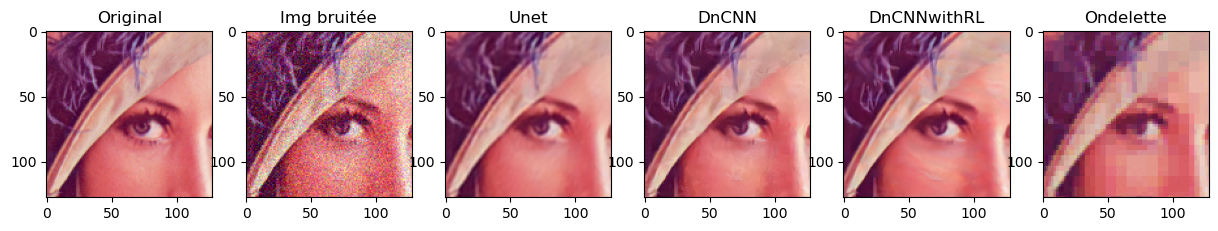

In [5]:
imageNette = Image.open('image/Lena128.png')
imageNette = TF.to_tensor(imageNette).unsqueeze(0).to(device)
imageBruite = Image.open('image/LenaSigma0.1.png')
imageBruite = TF.to_tensor(imageBruite).unsqueeze(0).to(device)


# Application des différents modèles
imageDebruiteeUnet = model(imageBruite).detach()
imageDebruiteDnCNN = model1(imageBruite).detach()
imageDebruiteDnCNNwithRL = model3(imageBruite).detach()
imageDebruiteeOndelette = DebruiteurOndelette(imageBruite, device=device)

# Calcul du PSNR
psnr_image_bruitee = compute_psnr(imageNette, imageBruite)
psnr_unet = compute_psnr(imageNette, imageDebruiteeUnet)
psnr_dncnn = compute_psnr(imageNette, imageDebruiteDnCNN)
psnr_dncnn_rl = compute_psnr(imageNette, imageDebruiteDnCNNwithRL)
psnr_ondelette = compute_psnr(imageNette, imageDebruiteeOndelette)

print('PSNR Image bruitée:', psnr_image_bruitee.item())
print('PSNR Unet:', psnr_unet.item())
print('PSNR DnCNN:', psnr_dncnn.item())
print('PSNR DnCNNwithRL:', psnr_dncnn_rl.item())
print('PSNR Ondelette:', psnr_ondelette.item())

# Conversion des images pour l'affichage
imageNette_np = imageNette.squeeze().permute(1, 2, 0).cpu().numpy()
imageBruite_np = imageBruite.squeeze().permute(1, 2, 0).cpu().numpy()
imageDebruiteeUnet_np = imageDebruiteeUnet.squeeze().permute(1, 2, 0).cpu().numpy()
imageDebruiteDnCNN_np = imageDebruiteDnCNN.squeeze().permute(1, 2, 0).cpu().numpy()
imageDebruiteDnCNNwithRL_np = imageDebruiteDnCNNwithRL.squeeze().permute(1, 2, 0).cpu().numpy()
imageDebruiteeOndelette_np = imageDebruiteeOndelette.squeeze().permute(1, 2, 0).cpu().numpy()

# Clip pour s'assurer que les images sont dans l'intervalle [0, 1]
imageNette_np = np.clip(imageNette_np, 0, 1)
imageBruite_np = np.clip(imageBruite_np, 0, 1)
imageDebruiteeUnet_np = np.clip(imageDebruiteeUnet_np, 0, 1)
imageDebruiteDnCNN_np = np.clip(imageDebruiteDnCNN_np, 0, 1)
imageDebruiteDnCNNwithRL_np = np.clip(imageDebruiteDnCNNwithRL_np, 0, 1)
imageDebruiteeOndelette_np = np.clip(imageDebruiteeOndelette_np, 0, 1)

# Affichage des images
plt.figure(figsize=(15, 15))
plt.subplot(1, 6, 1)
plt.subplot(1, 6, 1); plt.imshow(imageNette_np); plt.title('Original')
plt.subplot(1, 6, 2); plt.imshow(imageBruite_np); plt.title('Img bruitée')
plt.subplot(1, 6, 3); plt.imshow(imageDebruiteeUnet_np); plt.title('Unet')
plt.subplot(1, 6, 4); plt.imshow(imageDebruiteDnCNN_np); plt.title('DnCNN')
plt.subplot(1, 6, 5); plt.imshow(imageDebruiteDnCNNwithRL_np); plt.title('DnCNNwithRL')
plt.subplot(1, 6, 6); plt.imshow(imageDebruiteeOndelette_np); plt.title('Ondelette')
plt.show()

### Débruitage d'une image avec plus de bruit

PSNR Image bruitée: 13.135271072387695
PSNR Unet: 25.055997848510742
PSNR DnCNN train 0.25: 26.17689323425293
PSNR DnCNNwithRL: 15.50434684753418
PSNR Ondelette: 21.226600646972656


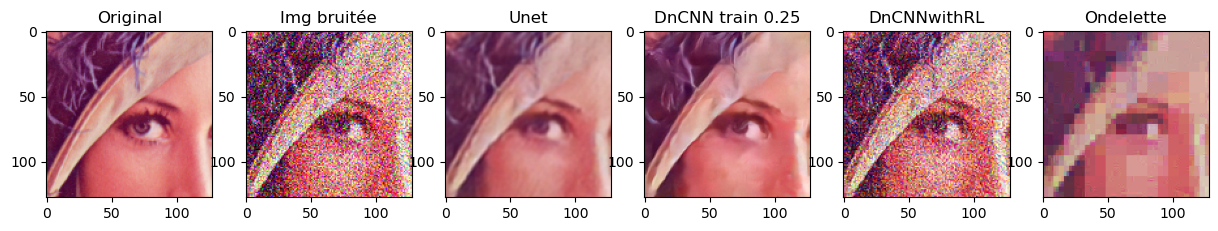

In [6]:
imageNette = Image.open('image/Lena128.png')
imageNette = TF.to_tensor(imageNette).unsqueeze(0).to(device)
imageBruite = Image.open('image/LenaSigma0.25.png')
imageBruite = TF.to_tensor(imageBruite).unsqueeze(0).to(device)


# Application des différents modèles
imageDebruiteeUnet = model(imageBruite).detach()
imageDebruiteDnCNN = model2(imageBruite).detach()
imageDebruiteDnCNNwithRL = model3(imageBruite).detach()
imageDebruiteeOndelette = DebruiteurOndelette(imageBruite, device=device)

# Calcul du PSNR
psnr_image_bruitee = compute_psnr(imageNette, imageBruite)
psnr_unet = compute_psnr(imageNette, imageDebruiteeUnet)
psnr_dncnn = compute_psnr(imageNette, imageDebruiteDnCNN)
psnr_dncnn_rl = compute_psnr(imageNette, imageDebruiteDnCNNwithRL)
psnr_ondelette = compute_psnr(imageNette, imageDebruiteeOndelette)

print('PSNR Image bruitée:', psnr_image_bruitee.item())
print('PSNR Unet:', psnr_unet.item())
print('PSNR DnCNN train 0.25:', psnr_dncnn.item())
print('PSNR DnCNNwithRL:', psnr_dncnn_rl.item())
print('PSNR Ondelette:', psnr_ondelette.item())

# Conversion des images pour l'affichage
imageNette_np = imageNette.squeeze().permute(1, 2, 0).cpu().numpy()
imageBruite_np = imageBruite.squeeze().permute(1, 2, 0).cpu().numpy()
imageDebruiteeUnet_np = imageDebruiteeUnet.squeeze().permute(1, 2, 0).cpu().numpy()
imageDebruiteDnCNN_np = imageDebruiteDnCNN.squeeze().permute(1, 2, 0).cpu().numpy()
imageDebruiteDnCNNwithRL_np = imageDebruiteDnCNNwithRL.squeeze().permute(1, 2, 0).cpu().numpy()
imageDebruiteeOndelette_np = imageDebruiteeOndelette.squeeze().permute(1, 2, 0).cpu().numpy()

# Clip pour s'assurer que les images sont dans l'intervalle [0, 1]
imageNette_np = np.clip(imageNette_np, 0, 1)
imageBruite_np = np.clip(imageBruite_np, 0, 1)
imageDebruiteeUnet_np = np.clip(imageDebruiteeUnet_np, 0, 1)
imageDebruiteDnCNN_np = np.clip(imageDebruiteDnCNN_np, 0, 1)
imageDebruiteDnCNNwithRL_np = np.clip(imageDebruiteDnCNNwithRL_np, 0, 1)
imageDebruiteeOndelette_np = np.clip(imageDebruiteeOndelette_np, 0, 1)

# Affichage des images
plt.figure(figsize=(15, 15))
plt.subplot(1, 6, 1)
plt.subplot(1, 6, 1); plt.imshow(imageNette_np); plt.title('Original')
plt.subplot(1, 6, 2); plt.imshow(imageBruite_np); plt.title('Img bruitée')
plt.subplot(1, 6, 3); plt.imshow(imageDebruiteeUnet_np); plt.title('Unet')
plt.subplot(1, 6, 4); plt.imshow(imageDebruiteDnCNN_np); plt.title('DnCNN train 0.25')
plt.subplot(1, 6, 5); plt.imshow(imageDebruiteDnCNNwithRL_np); plt.title('DnCNNwithRL')
plt.subplot(1, 6, 6); plt.imshow(imageDebruiteeOndelette_np); plt.title('Ondelette')
plt.show()

### Débruitage d'une image avec encore plus de bruit

PSNR Image bruitée: 9.102459907531738
PSNR Unet: 19.229129791259766
PSNR DnCNN train 0.25: 15.087647438049316
PSNR DnCNNwithRL: 10.576770782470703
PSNR Ondelette: 17.62096405029297


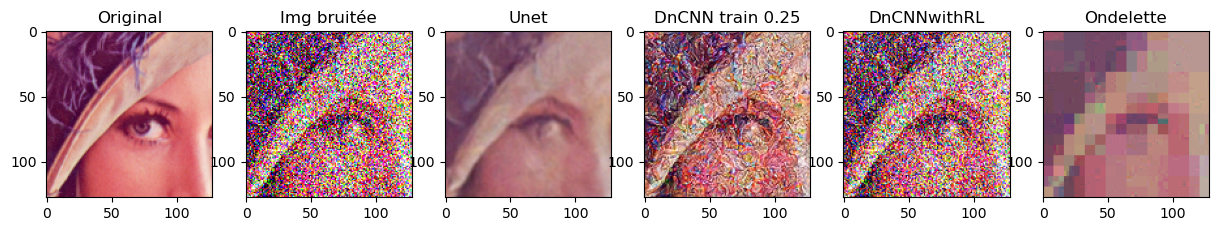

In [7]:
imageNette = Image.open('image/Lena128.png')
imageNette = TF.to_tensor(imageNette).unsqueeze(0).to(device)
imageBruite = Image.open('image/LenaSigma0.5.png')
imageBruite = TF.to_tensor(imageBruite).unsqueeze(0).to(device)


# Application des différents modèles
imageDebruiteeUnet = model(imageBruite).detach()
imageDebruiteDnCNN = model2(imageBruite).detach()
imageDebruiteDnCNNwithRL = model3(imageBruite).detach()
imageDebruiteeOndelette = DebruiteurOndelette(imageBruite, device=device)

# Calcul du PSNR
psnr_image_bruitee = compute_psnr(imageNette, imageBruite)
psnr_unet = compute_psnr(imageNette, imageDebruiteeUnet)
psnr_dncnn = compute_psnr(imageNette, imageDebruiteDnCNN)
psnr_dncnn_rl = compute_psnr(imageNette, imageDebruiteDnCNNwithRL)
psnr_ondelette = compute_psnr(imageNette, imageDebruiteeOndelette)

print('PSNR Image bruitée:', psnr_image_bruitee.item())
print('PSNR Unet:', psnr_unet.item())
print('PSNR DnCNN train 0.25:', psnr_dncnn.item())
print('PSNR DnCNNwithRL:', psnr_dncnn_rl.item())
print('PSNR Ondelette:', psnr_ondelette.item())

# Conversion des images pour l'affichage
imageNette_np = imageNette.squeeze().permute(1, 2, 0).cpu().numpy()
imageBruite_np = imageBruite.squeeze().permute(1, 2, 0).cpu().numpy()
imageDebruiteeUnet_np = imageDebruiteeUnet.squeeze().permute(1, 2, 0).cpu().numpy()
imageDebruiteDnCNN_np = imageDebruiteDnCNN.squeeze().permute(1, 2, 0).cpu().numpy()
imageDebruiteDnCNNwithRL_np = imageDebruiteDnCNNwithRL.squeeze().permute(1, 2, 0).cpu().numpy()
imageDebruiteeOndelette_np = imageDebruiteeOndelette.squeeze().permute(1, 2, 0).cpu().numpy()

# Clip pour s'assurer que les images sont dans l'intervalle [0, 1]
imageNette_np = np.clip(imageNette_np, 0, 1)
imageBruite_np = np.clip(imageBruite_np, 0, 1)
imageDebruiteeUnet_np = np.clip(imageDebruiteeUnet_np, 0, 1)
imageDebruiteDnCNN_np = np.clip(imageDebruiteDnCNN_np, 0, 1)
imageDebruiteDnCNNwithRL_np = np.clip(imageDebruiteDnCNNwithRL_np, 0, 1)
imageDebruiteeOndelette_np = np.clip(imageDebruiteeOndelette_np, 0, 1)

# Affichage des images
plt.figure(figsize=(15, 15))
plt.subplot(1, 6, 1)
plt.subplot(1, 6, 1); plt.imshow(imageNette_np); plt.title('Original')
plt.subplot(1, 6, 2); plt.imshow(imageBruite_np); plt.title('Img bruitée')
plt.subplot(1, 6, 3); plt.imshow(imageDebruiteeUnet_np); plt.title('Unet')
plt.subplot(1, 6, 4); plt.imshow(imageDebruiteDnCNN_np); plt.title('DnCNN train 0.25')
plt.subplot(1, 6, 5); plt.imshow(imageDebruiteDnCNNwithRL_np); plt.title('DnCNNwithRL')
plt.subplot(1, 6, 6); plt.imshow(imageDebruiteeOndelette_np); plt.title('Ondelette')
plt.show()

### Inpainting d'une image

PSNR Image bruitée: 17.038171768188477
PSNR Unet: 19.477771759033203
PSNR DnCNNwithRL: 17.979354858398438
PSNR DnCNNwithRLInpainting: 34.36113739013672
PSNR Ondelette: 18.829734802246094


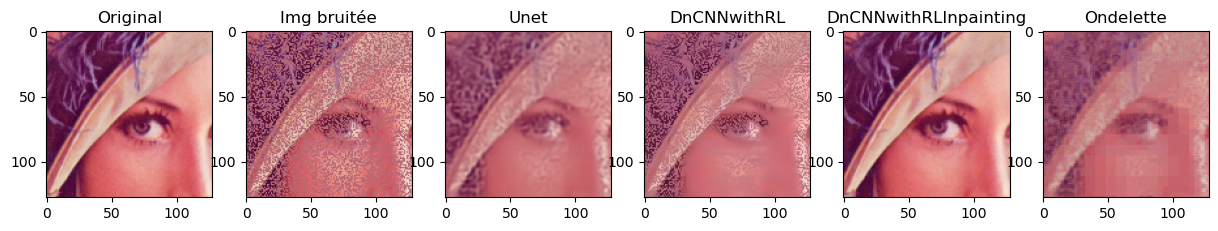

In [8]:
imageNette = Image.open('image/Lena128.png')
imageNette = TF.to_tensor(imageNette).unsqueeze(0).to(device)
imageBruite = Image.open('image/LenaInpainting.png')
imageBruite = TF.to_tensor(imageBruite).unsqueeze(0).to(device)


# Application des différents modèles
imageDebruiteeUnet = model(imageBruite).detach()
imageDebruiteDnCNNwithRL = model3(imageBruite).detach()
imageDebruiteDnCNNwithRLInpainting = model4(imageBruite).detach()
imageDebruiteeOndelette = DebruiteurOndelette(imageBruite, device=device)

# Calcul du PSNR
psnr_image_bruitee = compute_psnr(imageNette, imageBruite)
psnr_unet = compute_psnr(imageNette, imageDebruiteeUnet)
psnr_dncnn_rl = compute_psnr(imageNette, imageDebruiteDnCNNwithRL)
psnr_dncnn_rl_inpainting = compute_psnr(imageNette, imageDebruiteDnCNNwithRLInpainting)
psnr_ondelette = compute_psnr(imageNette, imageDebruiteeOndelette)

print('PSNR Image bruitée:', psnr_image_bruitee.item())
print('PSNR Unet:', psnr_unet.item())
print('PSNR DnCNNwithRL:', psnr_dncnn_rl.item())
print('PSNR DnCNNwithRLInpainting:', psnr_dncnn_rl_inpainting.item())
print('PSNR Ondelette:', psnr_ondelette.item())

# Conversion des images pour l'affichage
imageNette_np = imageNette.squeeze().permute(1, 2, 0).cpu().numpy()
imageBruite_np = imageBruite.squeeze().permute(1, 2, 0).cpu().numpy()
imageDebruiteeUnet_np = imageDebruiteeUnet.squeeze().permute(1, 2, 0).cpu().numpy()
imageDebruiteDnCNNwithRL_np = imageDebruiteDnCNNwithRL.squeeze().permute(1, 2, 0).cpu().numpy()
imageDebruiteDnCNNwithRLInpainting_np = imageDebruiteDnCNNwithRLInpainting.squeeze().permute(1, 2, 0).cpu().numpy()
imageDebruiteeOndelette_np = imageDebruiteeOndelette.squeeze().permute(1, 2, 0).cpu().numpy()

# Clip pour s'assurer que les images sont dans l'intervalle [0, 1]
imageNette_np = np.clip(imageNette_np, 0, 1)
imageBruite_np = np.clip(imageBruite_np, 0, 1)
imageDebruiteeUnet_np = np.clip(imageDebruiteeUnet_np, 0, 1)
imageDebruiteDnCNNwithRL_np = np.clip(imageDebruiteDnCNNwithRL_np, 0, 1)
imageDebruiteDnCNNwithRLInpainting_np = np.clip(imageDebruiteDnCNNwithRLInpainting_np, 0, 1)
imageDebruiteeOndelette_np = np.clip(imageDebruiteeOndelette_np, 0, 1)

# Affichage des images
plt.figure(figsize=(15, 15))
plt.subplot(1, 6, 1)
plt.subplot(1, 6, 1); plt.imshow(imageNette_np); plt.title('Original')
plt.subplot(1, 6, 2); plt.imshow(imageBruite_np); plt.title('Img bruitée')
plt.subplot(1, 6, 3); plt.imshow(imageDebruiteeUnet_np); plt.title('Unet')
plt.subplot(1, 6, 4); plt.imshow(imageDebruiteDnCNNwithRL_np); plt.title('DnCNNwithRL')
plt.subplot(1, 6, 5); plt.imshow(imageDebruiteDnCNNwithRLInpainting_np); plt.title('DnCNNwithRLInpainting')
plt.subplot(1, 6, 6); plt.imshow(imageDebruiteeOndelette_np); plt.title('Ondelette')
plt.show()

### Downsampling d'une image

PSNR Image bruitée: 24.359329223632812
PSNR Unet: 25.169357299804688
PSNR DnCNN: 15.087647438049316
PSNR DnCNNwithRL: 23.985790252685547
PSNR Ondelette: 24.774662017822266


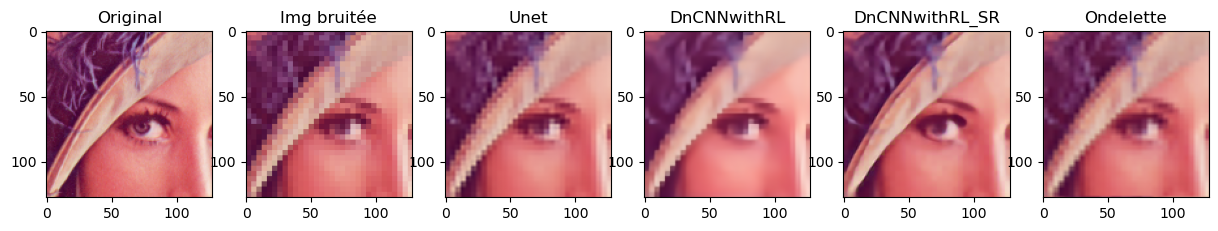

In [9]:
imageNette = Image.open('image/Lena128.png')
imageNette = TF.to_tensor(imageNette).unsqueeze(0).to(device)
imageBruite = Image.open('image/LenaDownsampled.png')
imageBruite = TF.to_tensor(imageBruite).unsqueeze(0).to(device)


# Application des différents modèles
imageDebruiteeUnet = model(imageBruite).detach()
imageDebruiteDnCNNwithRL = model3(imageBruite).detach()
imageDebruiteDnCNNwithRL_SR = model5(imageBruite).detach()
imageDebruiteeOndelette = DebruiteurOndelette(imageBruite, device=device)

# Calcul du PSNR
psnr_image_bruitee = compute_psnr(imageNette, imageBruite)
psnr_unet = compute_psnr(imageNette, imageDebruiteeUnet)
psnr_dncnn_rl = compute_psnr(imageNette, imageDebruiteDnCNNwithRL)
psnr_dncnn_rl_sr = compute_psnr(imageNette, imageDebruiteDnCNNwithRL_SR)
psnr_ondelette = compute_psnr(imageNette, imageDebruiteeOndelette)

print('PSNR Image bruitée:', psnr_image_bruitee.item())
print('PSNR Unet:', psnr_unet.item())
print('PSNR DnCNNwithRL:', psnr_dncnn_rl.item())
print('PSNR DnCNNwithRL_SR:', psnr_dncnn_rl_sr.item())
print('PSNR Ondelette:', psnr_ondelette.item())

# Conversion des images pour l'affichage
imageNette_np = imageNette.squeeze().permute(1, 2, 0).cpu().numpy()
imageBruite_np = imageBruite.squeeze().permute(1, 2, 0).cpu().numpy()
imageDebruiteeUnet_np = imageDebruiteeUnet.squeeze().permute(1, 2, 0).cpu().numpy()
imageDebruiteDnCNNwithRL_np = imageDebruiteDnCNNwithRL.squeeze().permute(1, 2, 0).cpu().numpy()
imageDebruiteDnCNNwithRL_SR_np = imageDebruiteDnCNNwithRL_SR.squeeze().permute(1, 2, 0).cpu().numpy()
imageDebruiteeOndelette_np = imageDebruiteeOndelette.squeeze().permute(1, 2, 0).cpu().numpy()

# Clip pour s'assurer que les images sont dans l'intervalle [0, 1]
imageNette_np = np.clip(imageNette_np, 0, 1)
imageBruite_np = np.clip(imageBruite_np, 0, 1)
imageDebruiteeUnet_np = np.clip(imageDebruiteeUnet_np, 0, 1)
imageDebruiteDnCNNwithRL_np = np.clip(imageDebruiteDnCNNwithRL_np, 0, 1)
imageDebruiteDnCNNwithRL_SR_np = np.clip(imageDebruiteDnCNNwithRL_SR_np, 0, 1)
imageDebruiteeOndelette_np = np.clip(imageDebruiteeOndelette_np, 0, 1)

# Affichage des images
plt.figure(figsize=(15, 15))
plt.subplot(1, 6, 1)
plt.subplot(1, 6, 1); plt.imshow(imageNette_np); plt.title('Original')
plt.subplot(1, 6, 2); plt.imshow(imageBruite_np); plt.title('Img bruitée')
plt.subplot(1, 6, 3); plt.imshow(imageDebruiteeUnet_np); plt.title('Unet')
plt.subplot(1, 6, 4); plt.imshow(imageDebruiteDnCNNwithRL_np); plt.title('DnCNNwithRL')
plt.subplot(1, 6, 5); plt.imshow(imageDebruiteDnCNNwithRL_SR_np); plt.title('DnCNNwithRL_SR')
plt.subplot(1, 6, 6); plt.imshow(imageDebruiteeOndelette_np); plt.title('Ondelette')
plt.show()